In [1]:
f = open('Profile-20180716T115056', 'r')

In [2]:
import json

data = json.load(f)

In [3]:
root_slices = []
counts = {}
start = None
end = None

for row in data:
    if row['ph'] != 'M':
        if start is None or int(row['ts']) < start:
            start = int(row['ts'])
        if end is None or int(row['ts']) > end:
            end = int(row['ts'])
    if row['cat'] == 'devtools.timeline' and row['name'] == 'FunctionCall':
        counts_key = str(row['pid']) + '_' + str(row['tid'])
        if row['ph'] == 'B':
            if counts_key not in counts:
                counts[counts_key] = { 'ts': row['ts'], 'tts': row['tts'], 'function_name': row['args']['data']['functionName'], 'children_count': 0 }
            else:
                counts[counts_key]['children_count'] = counts[counts_key]['children_count'] + 1
        elif row['ph'] == 'E':
            if counts[counts_key]['children_count'] > 0:
                counts[counts_key]['children_count'] = counts[counts_key]['children_count'] - 1
            else:
                root_slices.append({'function_name': counts[counts_key]['function_name'], 'start': counts[counts_key]['ts'], 't_start': counts[counts_key]['tts'], 'end': row['ts'], 't_end': row['tts']})
                del counts[counts_key]

In [39]:
import math

COL_BIN_SIZE = 1000000
ROW_BIN_SIZE = 20000

num_col_bins = math.ceil((end - start) / COL_BIN_SIZE)
num_row_bins = int(COL_BIN_SIZE / ROW_BIN_SIZE)

arr = [[0 for i in range(num_row_bins)] for j in range(num_col_bins)]

In [43]:
for s in root_slices:
    first_row_index = math.floor((s['start'] - start) / ROW_BIN_SIZE)
    last_row_index = math.ceil((s['end'] - start) / ROW_BIN_SIZE)
    for i in range(first_row_index, last_row_index):
        if i > 0:
            col_index = int(i // (COL_BIN_SIZE / ROW_BIN_SIZE))
            row_index = int(math.ceil(i % (COL_BIN_SIZE / ROW_BIN_SIZE)))
        else:
            col_index = 0
            row_index = 0
        arr[col_index][row_index] = arr[col_index][row_index] + 1

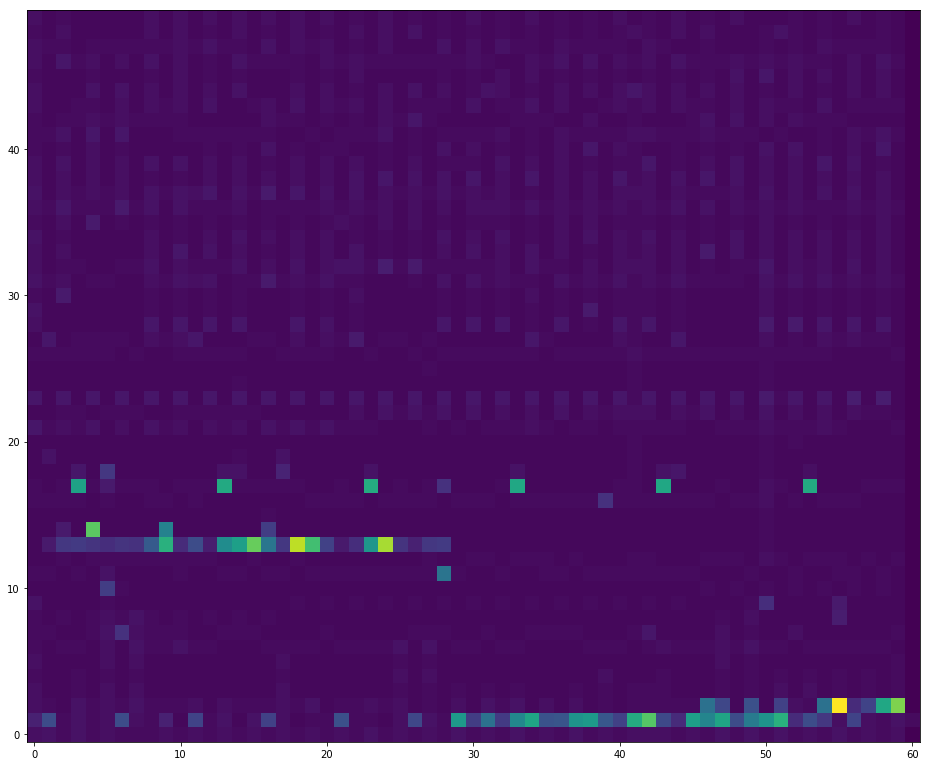

In [47]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [16, 16]

plt.imshow(np.transpose(arr), origin='lower')
plt.show()